In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# Define url
url = "https://min-api.cryptocompare.com/data/v2/histominute?fsym=BTC&tsym=USDT&limit=2000&aggregate=1&e=binance"

# Make the request
req = requests.get(url)

# Convert data to dictionary
req_json = req.json()

# Print out the keys of the dictionary
req_json.keys()

dict_keys(['Response', 'Message', 'HasWarning', 'Type', 'RateLimit', 'Data'])

In [3]:
data_list = req_json["Data"]["Data"][:]
close_prices = []
for i in range(len(data_list)):
    close_prices.append(data_list[i]["close"])
close_prices = np.array(close_prices)

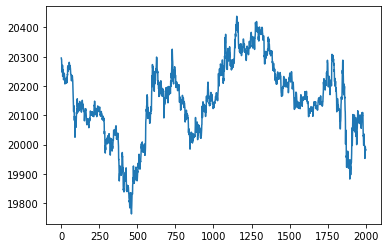

In [4]:
plt.plot(close_prices)

In [5]:
def to_batch(_arr,_frame_sizes):
    _frames = []
    _indexes = []
    for _frame_size in _frame_sizes:
        for i in range(_arr.shape[0]-_frame_size):
            _indexes.append([i,i+_frame_size])
            _frame = _arr[i:i+_frame_size]
            _frame = _frame.reshape(_frame.shape+(1,1))
            _frame = tf.image.resize(_frame,(96,1)).numpy()
            _frame = _frame.squeeze()
            _frame = (1e-7+_frame - np.min(_frame))/(1e-7+np.max(_frame)-np.min(_frame))
            _frames.append(_frame)
    return np.array(_frames),np.array(_indexes)

In [56]:
frame_sizes = [32,48,64,72,80,88,96,128,128+32,128+64,96*2,96*3,96*4,96*5,96*6,96*7,96*8]
frames,indexes = to_batch(close_prices,frame_sizes)

In [31]:
input_data = (frames-0.5)*2

In [8]:
model = keras.models.load_model("/Users/yahya/Desktop/quantiative/time_series/classification_model")

In [57]:
output_data = model.predict(input_data)
c_scores = output_data[0]
l_det = output_data[1]

In [63]:
THRESHOLD = 0.5

In [64]:
p_indexes = np.where(c_scores>THRESHOLD)[0]

In [65]:
p_scores = c_scores[p_indexes]
p_scales = l_det[p_indexes]
p_locs = indexes[p_indexes]
p_locs[:,0] = ((p_locs[:,1]-p_locs[:,0])*p_scales.squeeze()) + p_locs[:,0]

In [66]:
p_locs[:,0].shape

(169,)

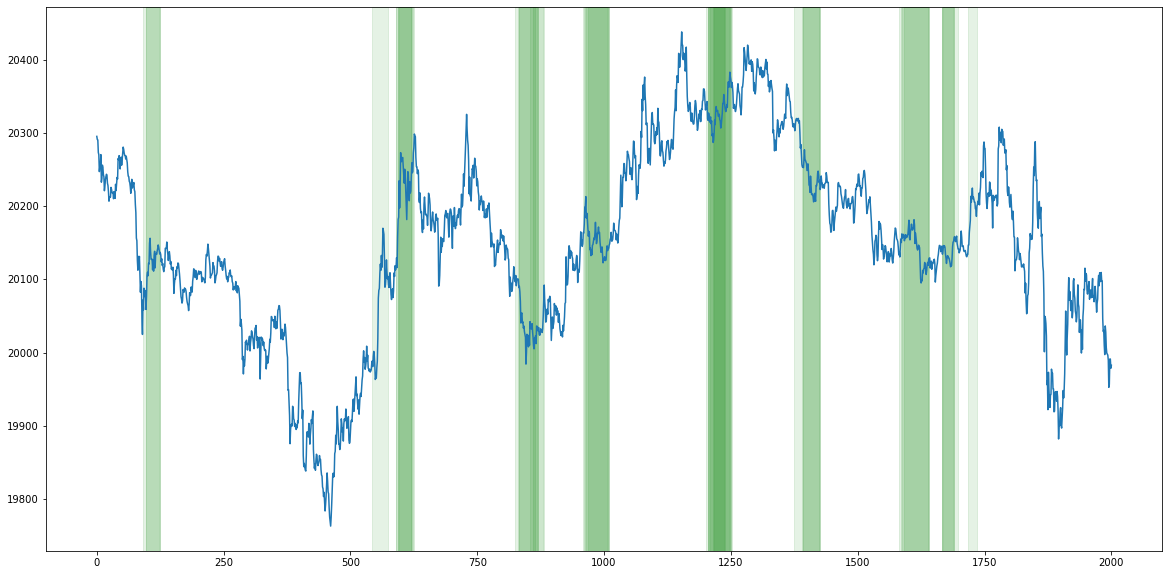

In [68]:
plt.figure(figsize=(20,10))
plt.plot(close_prices)
for i in range(p_locs.shape[0]):
    if p_locs[i,1]-p_locs[i,0]< 16:
        continue
    if np.where(p_scores[i] == np.max(p_scores[i]))[0][0] == 0:
        color_ = "black"
        continue
    elif np.where(p_scores[i] == np.max(p_scores[i]))[0][0] == 1:
        color_ = "red"
        continue
    elif np.where(p_scores[i] == np.max(p_scores[i]))[0][0] == 2:
        color_ = "green"
        
    elif np.where(p_scores[i] == np.max(p_scores[i]))[0][0] == 3:
        color_ = "blue"
        continue
        
    
    mn = np.min(close_prices[p_locs[i,0]:p_locs[i,1]])
    mx = np.max(close_prices[p_locs[i,0]:p_locs[i,1]])

    #plt.axhspan(mn,mx,color = color_,alpha=0.01)
    plt.axvspan(p_locs[i,0],p_locs[i,1],color=color_,alpha=0.1)
    # plt.axvline(p_locs[i,0],color="green",linewidth=0.1)
    # plt.axvline(p_locs[i,1],color="red",linewidth=0.1)
plt.show()